<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week04_Simple_MLP_Model_with_the_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 04

## Introduction

In this notebook we are going to take the first step into deep learning. We will build a very simple neural network model i.e. multi-layer perceptron (MLP) with PyTorch, then train it with the Iris dataset. Our goal is to implement an MLP model that can classify three different types of irises. 


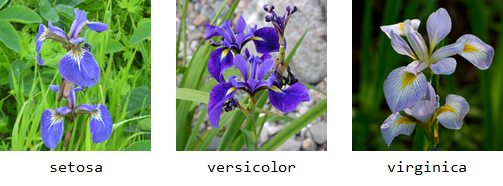

The model we will be using here is not really deep - so maybe we should not call it deep learning - but most of the required processes are common for deeper neural network models.


In this notebook we will learn
*   How the deep learning workflow looks like
*   How to build and train a simple MLP model
*   What are linear layer (fully-connected layer), activation function, loss function, optimizer.

First of all, let's import some general Python packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns     # data visualization package based on matplotlib

## Data Preparation

### Iris Dataset

The Iris dataset can be loaded from scikit-learn dataset (`sklearn.datasets`) module. scikit-learn is a very popular machine-learning package in Python. Although scikit-learn is not capable of deep learning, it has lots of useful tools for data processing and analysis for deep learning. We will use scikit-learn often in this lecture.

*   scikit-learn https://scikit-learn.org/stable/
*   Iris dataset https://en.wikipedia.org/wiki/Iris_flower_data_set

In [ ]:
from sklearn.datasets import load_iris

iris_data = load_iris()
print(iris_data)

The original Iris dataset is in Python dictionary format. In order to see the dataset more clearly, we can convert it to Pandas DataFrame format.

In [ ]:
df_iris = pd.DataFrame(iris_data["data"], columns=iris_data["feature_names"])
df_iris["label"] = iris_data["target"]
df_iris

As shown above, the dataset consisits of 4 feature values (sepal length, sepal width, petal length and petal width) and the label of iris type (target) of 150 samples. 

If you want to see n-th sample data,

In [ ]:
n = 50
df_iris.iloc[n]

By the way if you don't know what sepal and petal are, please refer below.

https://www.math.umd.edu/~petersd/666/html/iris_pca.html

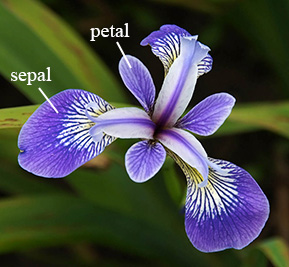

The label corresponds to three types of irises as shown in the table below.

|  label  |  name of iris  |
| :----: | :----: |
|  0  |  setosa  |
|  1  |  versicolor |
| 2| virginica|


To visualize relationships between features and labels, `sns.parplot()` may be useful.

In [ ]:
sns.pairplot(df_iris, hue="label", palette="dark")

The goal of this work is to implement a MLP model that can classify the type (name) of iris from its four feature values. Therefore, four feature values (sepal length, sepal width, petal length and petal width) will be input data `x` and the label number will be the output data `y` of the model.

In order to feed the data to PyTorch deep learning model, we need to do some preparations of the data - this is called preprocessings.

### torch.tensor

First we have to convert input and output data to `torch.tensor` so that PyTorch can handle them. Make sure that we set the data type (`dtype`) of `x` as `torch.float32` and `y` as `torch.int64`.

In [ ]:
import torch

x = torch.tensor(iris_data["data"], dtype=torch.float32)
y = torch.tensor(iris_data["target"], dtype=torch.int64)

### TensorDataset

Then we create `TensorDataset` object named `xy_dataset` from x and y data.

In [ ]:
from torch.utils.data import TensorDataset

xy_dataset = TensorDataset(x, y)
len(xy_dataset)

By indexing `xy_dataset`, we can access to input and output data of each sample.

In [ ]:
xy_dataset[50]

### train test split

We prepared `xy_dataset` for training the model. However we should not use all of them for training. 

Because we have to evaluate the model after the training. ***This evaluation must be done with data not used for training.*** So we need to split all of `xy_dataset` into training data (`xy_train`) and evaluation/testing data (`xy_test`).

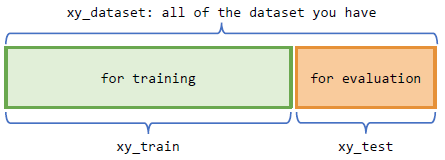

In [ ]:
from torch.utils.data import random_split

train_size = 100   # define train_size
test_size = 50     # define test_size

# randomly split xy_dataset into xy_train and xy_test
xy_train, xy_test = random_split(xy_dataset, [train_size, test_size])

# check length of xy_train and xy_test
print("xy_train", len(xy_train))
print("xy_test", len(xy_test))

### Data Loader

In order to feed the data to the model for training, we create `DataLoader`objects named `train_loader` and `test_loader`. 

Here we set the parameter of `batch_size=5`. This means we feed every 5 sets of input and output data to the model. Since the total amount of Iris dataset is not very big, we can actually feed all of the data to the model at once. But as we will see in the future, deep neural network models are traind with huge amount of data in many cases. In such cases it is not possible to feed those data at the same time because of limitation of memories. Also we can choose to shuffle the oder of the data or not. For most of the cases it is good to shuffle data for training.

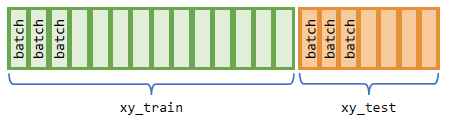

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=5, shuffle=True)
test_loader = DataLoader(xy_test, batch_size=5, shuffle=False)

By iterating the DataLoader in a for loop, we can take the input and output data with spacified batch size,

In [ ]:
for x_batch, y_batch in train_loader:
    print(x_batch)
    print(y_batch)
    break

That's it for data preparation!

## Building a Model

### Model Architecture

Next step is to build a neural network model. 

Here we are going to define a MLP model which consists of only three layers (input, hidden, output). The input layer has four neurons because we will feed four feature values there. The hidden layer can have any number of neurons. The output layer has three neurons which correspond to the number of iris types. The neuron with highest value among three neurons indicates the most probable iris type that the model predicted.

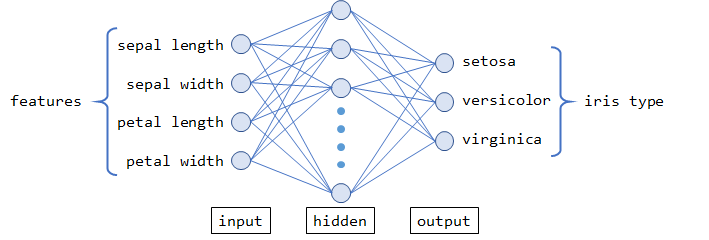

In PyTorch it is a customary to define a model with a custom Python class object, therefore we are going to follow this manner.

In [ ]:
import torch.nn as nn

# define a custom class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3)
        )
    
    # Instance method
    def forward(self, x):        # do not change
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

The model we defined here consists of Linear layers and an activation function of ReLU. But what do they do?

### Linear Layer

Let's say we have "layer0" with three neurons ($x_0$, $x_1$, $x_2$) followed by a Linear layer named "layer1" with two neurons ($y_0$, $y_1$). The neurons of $y_0$ and $y_1$ are connected with all neurons in layer0 with different weights ($w_{00}$, $w_{01}$, $w_{02}$, $w_{10}$, $w_{11}$, $w_{12}$) and biases ($b_0$, $b_1$).

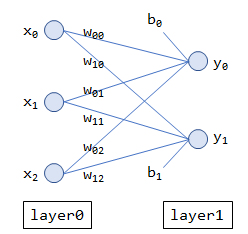

The values of $y_0$ and $y_1$ are calculated with the neurons' values in the previdous layer and the weights as well as biases as shown below. All weights and biases are trainable parameters of the model.


$y_0 = w_{00}x_0 + w_{01}x_1 + w_{02}x_2 + b_0$

$y_1 = w_{10}x_0 + w_{11}x_1 + w_{12}x_2 + b_1$

Let's try to do above calculations with codes.

In [ ]:
X = torch.tensor([0.2, 0.7, -0.5])     # [x0, x1, x2] nodes in layer0

W0 = torch.tensor([1.0, 0.1, 0.5])     # [w00, w01, w02] weights for y0
W1 = torch.tensor([-0.6, 0.8, 0.2])    # [w10, w11, w12] weights for y1
b0 = 0.5                               # bias for y0
b1 = -0.7                              # bias for y1

y0 = torch.sum(W0*X)+b0
y1 = torch.sum(W1*X)+b1

print("y0 =", y0)
print("y1 =", y1)

### ReLU - Activation Function

Usually a linear layer is followed by an activation function. This example shows an activation function called ReLU applied to the output of linear1 layer. ReLU stands for Rectified Linear Unit. It outputs 0 if the input is negative, and same value if the input is positive.

In [ ]:
def relu(x):
    return max(torch.tensor(0.0), x)

y0 = relu(y0)
y1 = relu(y1)

print("y0 =", y0)
print("y1 =", y1)

## Training

### Loss Function

During the training we have to know the "loss" value which indicates how wrong the current model prediction is. To measure the loss value quantitatively, we can use loss functions. The cross-entropy loss function (`nn.CrossEntropyLoss()`) is usually used for classification tasks.


* `nn.CrossEntropyLoss()` https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
loss_func = nn.CrossEntropyLoss()

According to the link above, the cross-entroly loss is determined by the equation below, where $p_i$ is prediction (output value of the model) for the $i_{th}$ category and $p_y$ is prediction for the ground truth label.  

$\displaystyle \mathrm{loss} =  -\ln\left(\exp(p_y)/\sum_{i=0}^{n-1} \exp(p_i)\right) = -p_y + \ln\left(\sum_{i=0}^{n-1} \exp(p_i)\right)$

Let's check this equation with codes.

In [ ]:
p = torch.tensor([0.1, 3, -2])    # model outputs i.e. predictions for 3 classes [setosa, versicolor, verginica]
y = torch.tensor(1)               # ground truth label index [versicolor]

loss = -p[y] + torch.log(torch.sum(torch.exp(p)))
loss

In [ ]:
p = torch.tensor([[0.1, 3, -2]])
y = torch.tensor([1])

loss_func(p, y)

### Optimizer

During the model training process, the model parameters (weights and biases) are updated in order to minimize the loss value. Algorithms for updating the model parameters are called optimizers. We use so-called "Adam" optmizer here, but there are several different optimizers. The parameter `lr` is learning rate that controls how much to change the model parameters in respose to the loss value.

* `optim.Adam()` https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop

Now we are ready for training the model. The code for training process is a bit long. But most part of the training processes is common for other datasets and models, therefore once you get used to it, it won't be a big deal anymore.

The main components of training loop are shown below.







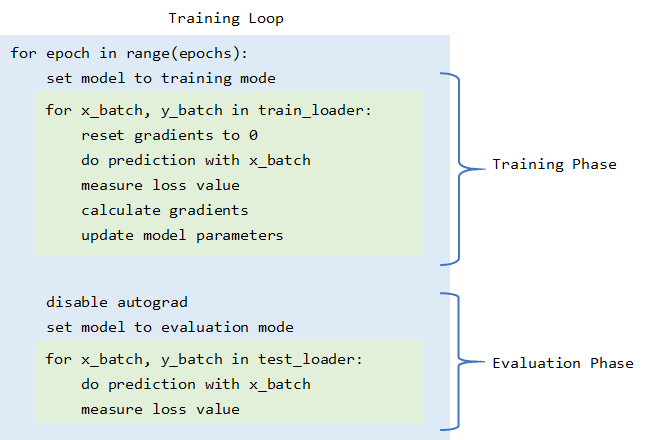

In [ ]:
model = Model()                                        # load model
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer


epochs = 50  # set total epochs

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

# training loop
for epoch in range(epochs):

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    for x_batch, y_batch in train_loader:      # take mini batch data from train_loader
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients of loss
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 
            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # calculate loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #------------------------#

    train_accuracy = train_correct_count/len(xy_train)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(xy_test)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)            # determine loss for training data
    test_loss = test_loss/len(test_loader)               # determine loss for test data 

    # show and store metrics
    print(f"Epoch {epoch+1} Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

### Learning Curves

After training the model it is always good to check how the training went, how the accuracy and loss changed.

Let's visualize accuracy curves for train and test data.

In [ ]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also let's vizualize loss curves for train and test data.

In [ ]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

## Evaluation

### Test Accuracy

Let's check accuracy of the trained model for the test data.

In [ ]:
test_correct_count = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 
        p_batch = model(x_batch)              # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
        test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.numpy())  # append p_batch_label in p_label_all

test_accuracy = test_correct_count/len(xy_test)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

### Confusion Matrix

It is also good to check the confusion matrix to know the accuracies for each categories.

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(7,6))
labels = iris_data["target_names"]

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=labels, yticklabels=labels, square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

## Prediction with New Data
Let's say we got a new input data, i.e. four feature values of a new unknown sample.

In [ ]:
# unknown sample data
sepal_l = 3.0
sepal_w = 2.0
petal_l = 1.0
petal_w = 0.5

x = [sepal_l, sepal_w, petal_l, petal_w]
x = torch.tensor([x], dtype=torch.float32)
print(x)

We can make a prediction for this new sample with the trained model. Note that we apply `nn.Softmax()`function to the predicted values. `nn.Softmax()` is defined by,

$\displaystyle \mathrm{Softmax}(x_i) = \exp(x_i)/\sum_{j=0}^{N-1}\exp(x_j)$

This rescales predicted values so that ranging from 0 to 1 and sum to 1.  We can take these rescaled values as probabilities for three Iris types.

In [ ]:
with torch.no_grad():      
    pred = model(x)
    print("pred =", pred)
    
    softmax = nn.Softmax()
    prob = softmax(pred[0])
    print("prob =", prob)

In [ ]:
print("Probablity")
print(f"setosa {prob[0].item():.1%}")
print(f"vesicolor {prob[1].item():.1%}")
print(f"virginica {prob[2].item():.1%}")

## Practice

Try to modify the MLP model so that


*   it has 2 hidden layers
*   first hidden layer has 10 neurons and followed by ReLU activation function
*   second hidden layer has 20 neurons and followed by ReLU activation function


 and then train it again!

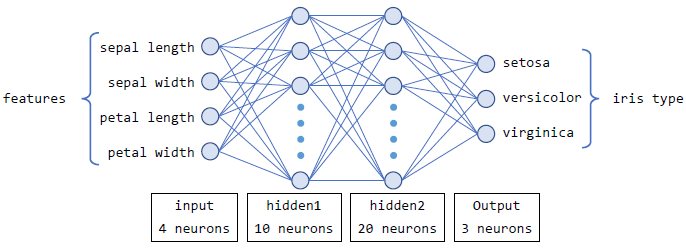

## Conclusion

That's it for this week. We have learned very basics of deep learning. Now you could try to change some hyper parameters listed below and see how the result changes.



* batch size in data loader
*   number of neurons in hidden layer
*   number of hidden layers
*  learning rate of optimizers
* type of optimizers
* number of epochs
* etc.


